<img src="./unb.png" alt="" width="400" height="300">

# Análise do Modelo SIR com Dados Reais
### Aluno: Jânio Lucas Carrilho 232013891

O intuito deste projeto é uma tentativa de prever curvas de progressão da COVID-19 no Brasil em dois casos, sem ações tomadas e isolamento social em conjunto com quarentena, utilizando o modelo SIR e dados acerca da taxa de espalhamento da doença fornecidos do Ministério da Saúde e da ONG Our World in Data. A tentativa sera realizada por meio da linguagem Python em conjunto com as bibliotecas Pandas para organização e manipulação dos dados, Scipy para EDOs e Myplotlib para visualização.
   - Os coeficientes usados foram extraidos do artigo https://www.joserobertoafonso.com.br/modeling-and-forecasting-the-covid-19-pandemic-in-brazil-bastos-cajueiro/.

### Modelo SIR:
   O modelo SIR é um tipo de modelo compartimental usado em epidemiologia para simular a propagação de doenças infecciosas. O modelo divide a população em três compartimentos:
    
   - **S(Susceptible):** Indivíduos suscetíveis à infecção
   - **I(Infected):** Indivíduos infectados
   - **R(Recovered):** Indivíduos recuperados ou removidos (imunes ou mortos)

As equações diferenciais do modelo SIR são:
    $$
    \frac{dS}{dt} = -\beta SI
    $$
    
   $$
    \frac{dI}{dt} = \beta SI - \gamma I
   $$
    
$$
    \frac{dR}{dt} = \gamma I
$$

Onde:
 - $\beta$ é a taxa de transmissão (probabilidade de contato entre S e I que resulta em infecção)
 - $\gamma$ é a taxa de recuperação (proporção de infectados que se recuperam ou são removidos por unidade de tempo)

## Importação e Limpeza dos Dados

In [30]:
import pandas as pd

data = './data.csv'

# Carregando os dados
data = pd.read_csv(data)

# Exibir as primeiras linhas do dataset
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


#### Filtrando os Dados e Pré-processamento:
Podemos ver que a tabela acima possui dados de vários países. Neste projeto irei filtrar os dados do Brasil e apenas as colunas relevantes para este projeto.

Como neste dataset não possui dados sobre o números de recuperados irei fazer uma estimativa, sendo o número de recuperados a subtração entre o número total de casos e a soma entre número de mortes mais os casos ativos.


In [31]:
br_data = data[data['location'] == 'Brazil']

#Pré-processamneto
br_data = br_data.sort_values('date')

#Selecionar colunas relevantes
br_data = br_data[['date', 'total_cases', 'total_deaths', 'population']]

#Excluir valores nulos
br_data = br_data.dropna()

br_data.head()

,date,total_cases,total_deaths,population
48437,2020-03-22,904.0,11.0,215313504.0
48438,2020-03-23,904.0,11.0,215313504.0
48439,2020-03-24,904.0,11.0,215313504.0
48440,2020-03-25,904.0,11.0,215313504.0
48441,2020-03-26,904.0,11.0,215313504.0


## Implementação do modelo SIR em Pyhton
#### Função SIR:
- Primeiro irei criar uma função difeq que ira servir como representação do modelo SIR no código em python.
- Depois irei colocar os parâmetros e em seguida achar a solução usando uma função chamada odeint

A função odeint é utilizada para resolver sistemas de equações diferenciais ordinárias (EDOs) numéricamente. EDOs são equações que descrevem como uma variável muda com relação ao tempo, dependendo do seu valor atual e de outras variáveis.

### COVID-19 no Brasil
De acordo com o Minstério do Brasil, a taxa de transmissão é baseado nos seguintes coeficientes:
- $\beta$ é de 0.449, devido a quarentena e isolação social.
- $\gamma$ de 5.2 dias.

In [32]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def deriv(y, t, N, beta, gama):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gama * I
    dRdt = gama * I
    return dSdt, dIdt, dRdt

def sir(N, beta, gama=1/10, I0=1, R0=0, t=90):
    t = np.linspace(0, t, t)
    S0 = N - I0 - R0
    y0 = S0, I0, R0
    ret = odeint(deriv, y0, t, args=(N, beta, gama))
    S, I, R = ret.T
    return {'S': S, 'I': I, 'R': R, 't': t}

def curves(s, title):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(s['t'], s['S'], 'b', alpha=0.5, lw=4, label='Sucetíveis')
    plt.plot(s['t'], s['I'], 'r', alpha=0.5, lw=4, label='Infectados')
    plt.plot(s['t'], s['R'], 'g', alpha=0.5, lw=4, label='Recuperados')
    plt.grid(which='major', axis='y')
    plt.ticklabel_format(scilimits=(6,6), axis='y')
    plt.text(0.9,1,s='β: %.3f γ: %.2f' % (beta, gama), transform=ax.transAxes, fontsize=10)
    plt.title(title, fontsize=14, fontweight='bold', color='#333333')
    plt.xlabel('Dias', fontsize=12)
    plt.ylabel('Número de casos em milhão', fontsize=12)
    legend = plt.legend(loc=5, fontsize=12)
    ax.set_ylim(0)
    [ax.spines[spine].set_visible(False) for spine in ('top', 'right', 'left')]
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
    plt.show();

## Sem Ações Tomadas
O proximo modelo simula um contexo onde nennhuma ação social foi tomada. A duração media de infecção é 5.2 e a taxa de infeccção é 2.2 segundo, https://www.nejm.org/doi/full/10.1056/NEJMe2002387. 

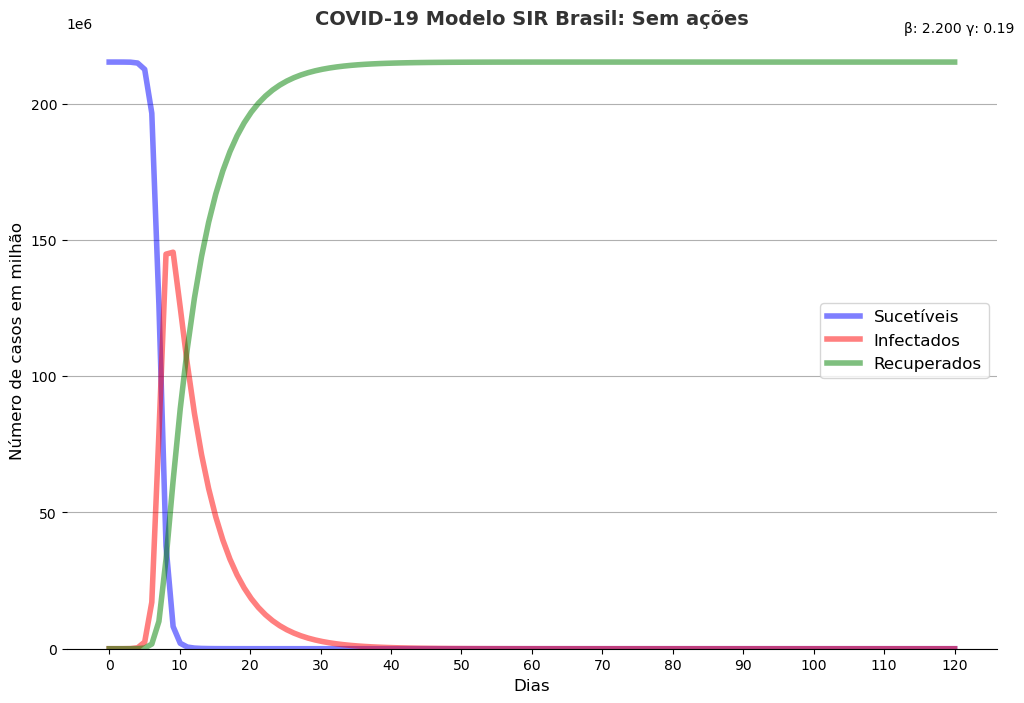

In [33]:
gama = 1/5.2
beta = 2.2
curves(sir(br_data['population'].values[0] , beta, gama, t=120, I0=100), 'COVID-19 Modelo SIR Brasil: Sem ações')

## Distância Social e Quarentena
O proximo modelo simula onde a população é orientada a manter distância social e ficar em quarentena.

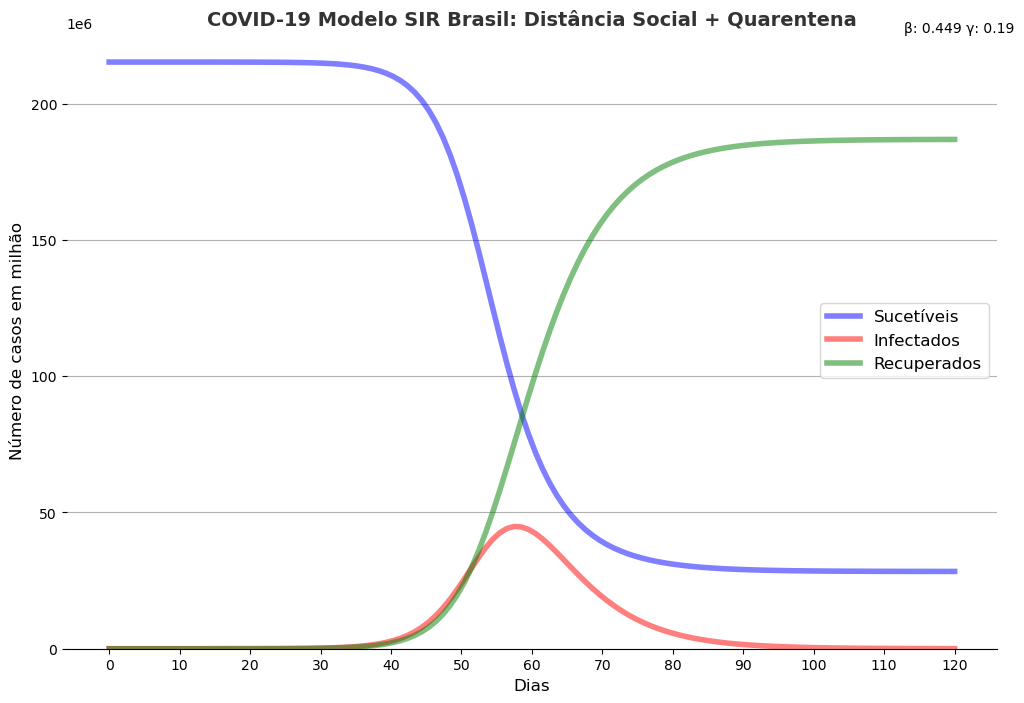

In [34]:
beta = 0.449
curves(sir(br_data['population'].values[0], beta, gama, t=120, I0=100), 'COVID-19 Modelo SIR Brasil: Distância Social + Quarentena')


# Conclusão
Podemos tomar como conclusão que o pico de número de infectados no caso em que nenhuma ação foi tomada é muito elevado, isso poderia desencadear várias consequências, como por exemplo o colapso do sistema de saúde do país. Então, foi providencial a tomada de medidas de distância social em conjunto com a quarentena para evitar esse tipo de consequência.

Falando agora da minha experiência com este projeto, devido a complexidade da pandêmia e a exclusão de variáveis como por exemplo, a vacinação da população, estes modelos não foram tão eficazes. O foco foi apenas em trabalhar com a Equação Diferencial e com dados reais.